In [1]:
!pip install visualkeras seaborn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152V2, ResNet101V2, EfficientNetB3, EfficientNetV2L
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [3]:
tf.keras.backend.clear_session()

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'

In [5]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

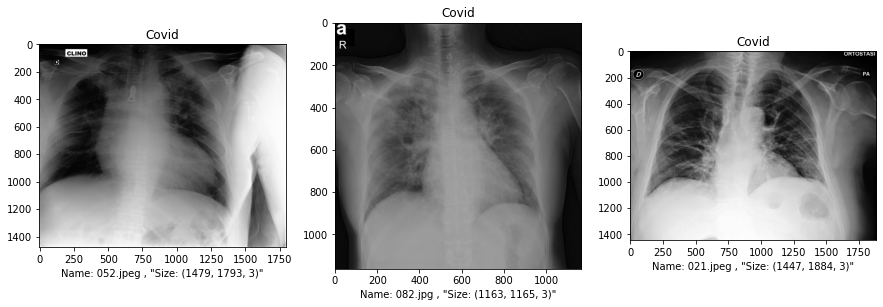

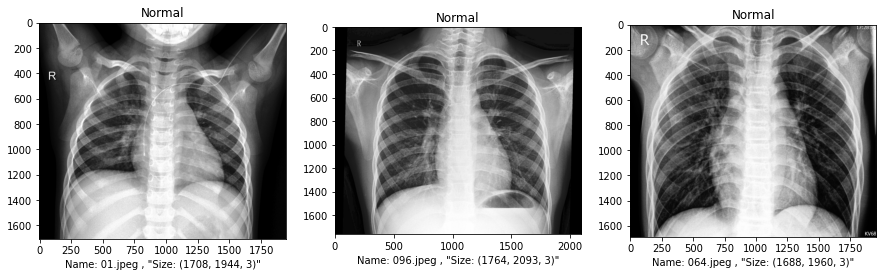

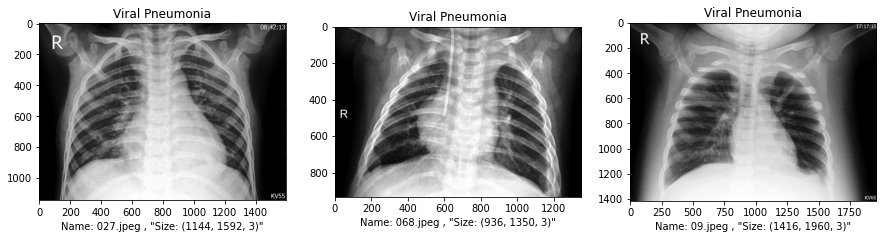

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [9]:
img_size = 512
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
base_model = EfficientNetV2L(weights='imagenet', include_top=False, pooling='max',
                             input_shape=(img_size, img_size, 3)) 

# freeze extraction layers
base_model.trainable = True

# add custom top layers
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.6)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# x = Dense(1024, kernel_regularizer = regularizers.l2(l=0.020),activity_regularizer=regularizers.l1(0.008),
#           bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, kernel_regularizer = regularizers.l2(l=0.020),activity_regularizer=regularizers.l1(0.008),
#           bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256, kernel_regularizer = regularizers.l2(l=0.020),activity_regularizer=regularizers.l1(0.008),
#           bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(128, kernel_regularizer = regularizers.l2(l=0.020),activity_regularizer=regularizers.l1(0.008),
#           bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
# x = Dropout(0.3)(x)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [11]:
!pip install pydot

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 256, 256, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 128, 128, 25  147456      ['block2a_project_bn[0][0]']     
                                6)                                                                
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 128, 128, 25  1024       ['block2b_expand_conv[0][0]']    
 ization)                       6)                                                                
                                                                                                  
 block2b_expand_activation (Act  (None, 128, 128, 25  0          ['block2b_expand_bn[0][0]']      
 ivation)                       6)                                                                
                                                                                                  
 block2b_p

                                )                                ']                               
                                                                                                  
 block2f_project_bn (BatchNorma  (None, 128, 128, 64  256        ['block2f_project_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 block2f_add (Add)              (None, 128, 128, 64  0           ['block2f_project_bn[0][0]',     
                                )                                 'block2e_add[0][0]']            
                                                                                                  
 block2g_expand_conv (Conv2D)   (None, 128, 128, 25  147456      ['block2f_add[0][0]']            
                                6)                                                                
          

                                                                 ']                               
                                                                                                  
 block3d_project_bn (BatchNorma  (None, 64, 64, 96)  384         ['block3d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3d_add (Add)              (None, 64, 64, 96)   0           ['block3d_project_bn[0][0]',     
                                                                  'block3c_add[0][0]']            
                                                                                                  
 block3e_expand_conv (Conv2D)   (None, 64, 64, 384)  331776      ['block3d_add[0][0]']            
                                                                                                  
 block3e_e

 block4a_se_expand (Conv2D)     (None, 1, 1, 384)    9600        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 32, 32, 384)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 32, 32, 192)  73728       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 32, 32, 192)  768        ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_e

                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 32, 32, 768)  147456      ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4d_expand_activation (Act  (None, 32, 32, 768)  0          ['block4d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4d_dwconv2 (DepthwiseConv  (None, 32, 32, 768)  6912       ['block4d_expand_activation[0][0]
 2D)      

 block4f_dwconv2 (DepthwiseConv  (None, 32, 32, 768)  6912       ['block4f_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4f_bn (BatchNormalization  (None, 32, 32, 768)  3072       ['block4f_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4f_activation (Activation  (None, 32, 32, 768)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 768)         0           ['block4f_activation[0][0]']     
 agePoolin

 block4h_se_squeeze (GlobalAver  (None, 768)         0           ['block4h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4h_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4h_se_squeeze[0][0]']     
                                                                                                  
 block4h_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4h_se_reshape[0][0]']     
                                                                                                  
 block4h_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4h_se_reduce[0][0]']      
                                                                                                  
 block4h_se_excite (Multiply)   (None, 32, 32, 768)  0           ['block4h_activation[0][0]',     
          

 block4j_se_excite (Multiply)   (None, 32, 32, 768)  0           ['block4j_activation[0][0]',     
                                                                  'block4j_se_expand[0][0]']      
                                                                                                  
 block4j_project_conv (Conv2D)  (None, 32, 32, 192)  147456      ['block4j_se_excite[0][0]']      
                                                                                                  
 block4j_project_bn (BatchNorma  (None, 32, 32, 192)  768        ['block4j_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4j_add (Add)              (None, 32, 32, 192)  0           ['block4j_project_bn[0][0]',     
                                                                  'block4i_add[0][0]']            
          

                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 32, 32, 1344  301056      ['block5b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 32, 32, 1344  5376       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 32, 32, 1344  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_d

 block5e_expand_activation (Act  (None, 32, 32, 1344  0          ['block5e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 32, 32, 1344  12096      ['block5e_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 32, 32, 1344  5376       ['block5e_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 32, 32, 1344  0          ['block5e_bn[0][0]']             
 )        

 )                              )                                                                 
                                                                                                  
 block5g_activation (Activation  (None, 32, 32, 1344  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_s

                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_se_excite (Multiply)   (None, 32, 32, 1344  0           ['block5i_activation[0][0]',     
                                )                                 'block5i_se_expand[0][0]']      
                                                                                                  
 block5i_p

 block5k_se_excite (Multiply)   (None, 32, 32, 1344  0           ['block5k_activation[0][0]',     
                                )                                 'block5k_se_expand[0][0]']      
                                                                                                  
 block5k_project_conv (Conv2D)  (None, 32, 32, 224)  301056      ['block5k_se_excite[0][0]']      
                                                                                                  
 block5k_project_bn (BatchNorma  (None, 32, 32, 224)  896        ['block5k_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5k_add (Add)              (None, 32, 32, 224)  0           ['block5k_project_bn[0][0]',     
                                                                  'block5j_add[0][0]']            
          

                                                                                                  
 block5m_add (Add)              (None, 32, 32, 224)  0           ['block5m_project_bn[0][0]',     
                                                                  'block5l_add[0][0]']            
                                                                                                  
 block5n_expand_conv (Conv2D)   (None, 32, 32, 1344  301056      ['block5m_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5n_expand_bn (BatchNormal  (None, 32, 32, 1344  5376       ['block5n_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5n_e

 block5p_expand_bn (BatchNormal  (None, 32, 32, 1344  5376       ['block5p_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5p_expand_activation (Act  (None, 32, 32, 1344  0          ['block5p_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5p_dwconv2 (DepthwiseConv  (None, 32, 32, 1344  12096      ['block5p_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5p_bn (BatchNormalization  (None, 32, 32, 1344  5376       ['block5p_dwconv2[0][0]']        
 )        

 2D)                            )                                ']                               
                                                                                                  
 block5r_bn (BatchNormalization  (None, 32, 32, 1344  5376       ['block5r_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5r_activation (Activation  (None, 32, 32, 1344  0          ['block5r_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5r_se_squeeze (GlobalAver  (None, 1344)        0           ['block5r_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 16, 16, 2304  0           ['block6c_activation[0][0]',     
                                )                                 'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 16, 16, 384)  884736      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 16, 16, 384)  1536       ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_add (Add)              (None, 16, 16, 384)  0           ['block6c_project_bn[0][0]',     
                                                                  'block6b_add[0][0]']            
          

                                                                                                  
 block6e_add (Add)              (None, 16, 16, 384)  0           ['block6e_project_bn[0][0]',     
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 16, 16, 2304  884736      ['block6e_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 16, 16, 2304  9216       ['block6f_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6f_e

 block6h_expand_bn (BatchNormal  (None, 16, 16, 2304  9216       ['block6h_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6h_expand_activation (Act  (None, 16, 16, 2304  0          ['block6h_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 16, 16, 2304  20736      ['block6h_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 16, 16, 2304  9216       ['block6h_dwconv2[0][0]']        
 )        

 2D)                            )                                ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 16, 16, 2304  9216       ['block6j_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block6j_activation (Activation  (None, 16, 16, 2304  0          ['block6j_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6j_se_squeeze (GlobalAver  (None, 2304)        0           ['block6j_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block6l_se_squeeze (GlobalAver  (None, 2304)        0           ['block6l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6l_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6l_se_squeeze[0][0]']     
                                                                                                  
 block6l_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6l_se_reshape[0][0]']     
                                                                                                  
 block6l_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6l_se_reduce[0][0]']      
                                                                                                  
 block6l_s

                                                                                                  
 block6n_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6n_se_reduce[0][0]']      
                                                                                                  
 block6n_se_excite (Multiply)   (None, 16, 16, 2304  0           ['block6n_activation[0][0]',     
                                )                                 'block6n_se_expand[0][0]']      
                                                                                                  
 block6n_project_conv (Conv2D)  (None, 16, 16, 384)  884736      ['block6n_se_excite[0][0]']      
                                                                                                  
 block6n_project_bn (BatchNorma  (None, 16, 16, 384)  1536       ['block6n_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6p_project_bn (BatchNorma  (None, 16, 16, 384)  1536       ['block6p_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6p_add (Add)              (None, 16, 16, 384)  0           ['block6p_project_bn[0][0]',     
                                                                  'block6o_add[0][0]']            
                                                                                                  
 block6q_expand_conv (Conv2D)   (None, 16, 16, 2304  884736      ['block6p_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6q_e

 block6s_expand_conv (Conv2D)   (None, 16, 16, 2304  884736      ['block6r_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6s_expand_bn (BatchNormal  (None, 16, 16, 2304  9216       ['block6s_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6s_expand_activation (Act  (None, 16, 16, 2304  0          ['block6s_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6s_dwconv2 (DepthwiseConv  (None, 16, 16, 2304  20736      ['block6s_expand_activation[0][0]
 2D)      

 ivation)                       )                                                                 
                                                                                                  
 block6u_dwconv2 (DepthwiseConv  (None, 16, 16, 2304  20736      ['block6u_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block6u_bn (BatchNormalization  (None, 16, 16, 2304  9216       ['block6u_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block6u_activation (Activation  (None, 16, 16, 2304  0          ['block6u_bn[0][0]']             
 )                              )                                                                 
          

                                                                                                  
 block6w_activation (Activation  (None, 16, 16, 2304  0          ['block6w_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6w_se_squeeze (GlobalAver  (None, 2304)        0           ['block6w_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6w_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6w_se_squeeze[0][0]']     
                                                                                                  
 block6w_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6w_se_reshape[0][0]']     
          

 block6y_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6y_se_squeeze[0][0]']     
                                                                                                  
 block6y_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6y_se_reshape[0][0]']     
                                                                                                  
 block6y_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6y_se_reduce[0][0]']      
                                                                                                  
 block6y_se_excite (Multiply)   (None, 16, 16, 2304  0           ['block6y_activation[0][0]',     
                                )                                 'block6y_se_expand[0][0]']      
                                                                                                  
 block6y_project_conv (Conv2D)  (None, 16, 16, 384)  884736      ['block6y_se_excite[0][0]']      
          

                                                                                                  
 block7b_project_bn (BatchNorma  (None, 16, 16, 640)  2560       ['block7b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_add (Add)              (None, 16, 16, 640)  0           ['block7b_project_bn[0][0]',     
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 16, 16, 3840  2457600     ['block7b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block7c_e

 block7e_expand_conv (Conv2D)   (None, 16, 16, 3840  2457600     ['block7d_add[0][0]']            
                                )                                                                 
                                                                                                  
 block7e_expand_bn (BatchNormal  (None, 16, 16, 3840  15360      ['block7e_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block7e_expand_activation (Act  (None, 16, 16, 3840  0          ['block7e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7e_dwconv2 (DepthwiseConv  (None, 16, 16, 3840  34560      ['block7e_expand_activation[0][0]
 2D)      

 ivation)                       )                                                                 
                                                                                                  
 block7g_dwconv2 (DepthwiseConv  (None, 16, 16, 3840  34560      ['block7g_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block7g_bn (BatchNormalization  (None, 16, 16, 3840  15360      ['block7g_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block7g_activation (Activation  (None, 16, 16, 3840  0          ['block7g_bn[0][0]']             
 )                              )                                                                 
          

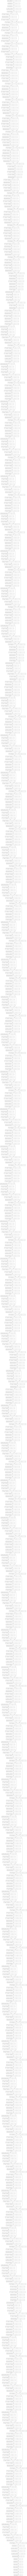

In [13]:
plot_model(model, to_file='./images/effL_model.png', show_shapes=True, show_layer_names=True)

In [14]:
visualkeras.layered_view(model, legend=True)

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=1), 
             ModelCheckpoint('./models/effL_model.h5', save_best_only=True)]

In [16]:
opt = Adamax(learning_rate=0.001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy']) 

In [17]:
DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100


2022-05-22 05:50:33.660325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-05-22 05:50:36.173483: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 63s 2s/step - loss: 2.0313 - accuracy: 0.3825 - val_loss: 3.5378 - val_accuracy: 0.2879
Epoch 2/100
16/16 [==============================] - 27s 2s/step - loss: 1.4836 - accuracy: 0.4900 - val_loss: 2.5430 - val_accuracy: 0.3030
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.1216 - accuracy: 0.6255 - val_loss: 1.5493 - val_accuracy: 0.5909
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 1.0234 - accuracy: 0.6534 - val_loss: 1.9143 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.1114 - accuracy: 0.6335 - val_loss: 0.5088 - val_accuracy: 0.7273
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.9164 - accuracy: 0.6693 - val_loss: 0.6682 - val_accuracy: 0.6970
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 0.7965 - accuracy: 0.7171 - val_loss: 0.4154 - val_accuracy: 0.8030
Epoch 8/100
16/16 [======

In [19]:
model = load_model('./models/effL_model.h5')

In [20]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

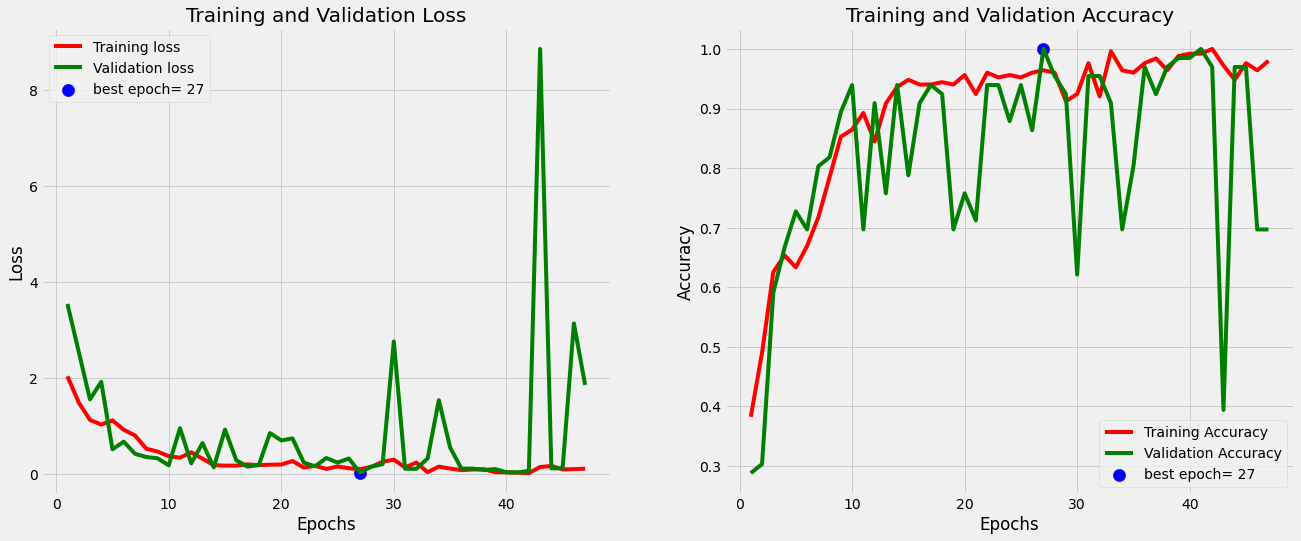

In [21]:
tr_plot(history, 0)

In [22]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 7s 45ms/step - loss: 0.0231 - accuracy: 1.0000
Loss: 2.309
Accuracy: 100.000


In [23]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int32))

In [24]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [25]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [26]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [27]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[26  0  0]
 [ 0 20  0]
 [ 0  0 20]]


F1 Score: 1.0


                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      1.00      1.00        20
Viral Pneumonia       1.00      1.00      1.00        20

       accuracy                           1.00        66
      macro avg       1.00      1.00      1.00        66
   weighted avg       1.00      1.00      1.00        66



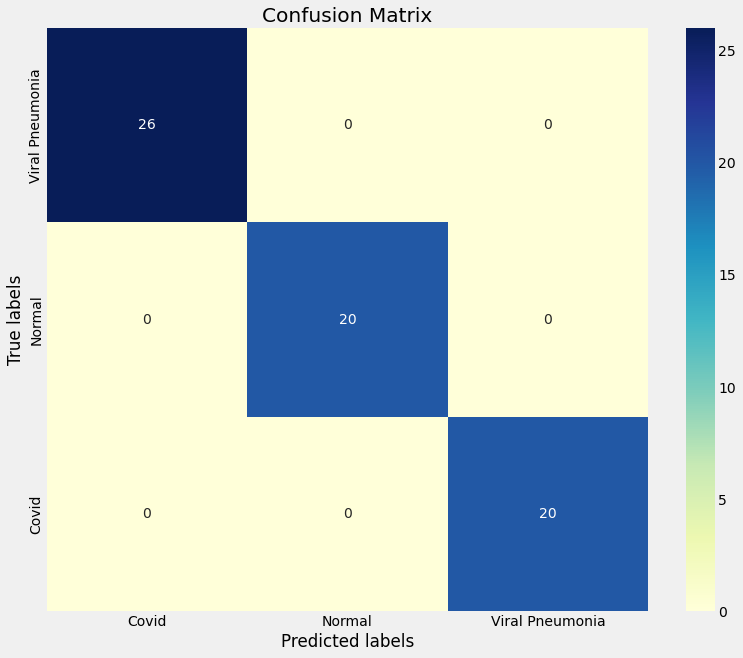

In [28]:
cal_score(model, plot=True)